## Problem 1

In [115]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "/Users/liruiqi/Desktop/545hw/project02/DailyPrices.csv"
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Selecting the stocks
stocks = ['SPY', 'AAPL', 'EQIX']

# A. Arithmetic Returns
arithmetic_returns = df[stocks].pct_change().dropna()
arithmetic_returns -= arithmetic_returns.mean()  # Remove mean

# Display last 5 rows and total standard deviation
print("Arithmetic Returns (Last 5 Rows):\n", arithmetic_returns.tail())
print(arithmetic_returns.std())



Arithmetic Returns (Last 5 Rows):
                  SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011492 -0.014678 -0.006966
2024-12-30 -0.012377 -0.014699 -0.008064
2024-12-31 -0.004603 -0.008493  0.006512
2025-01-02 -0.003422 -0.027671  0.000497
2025-01-03  0.011538 -0.003445  0.015745
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64


In [116]:
# B. Log Returns
log_returns = np.log(df[stocks] / df[stocks].shift(1)).dropna()
log_returns -= log_returns.mean()

# Display last 5 rows and total standard deviation
print("\nLog Returns (Last 5 Rows):\n", log_returns.tail())
print(log_returns.std())


Log Returns (Last 5 Rows):
                  SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011515 -0.014675 -0.006867
2024-12-30 -0.012410 -0.014696 -0.007972
2024-12-31 -0.004577 -0.008427  0.006602
2025-01-02 -0.003392 -0.027930  0.000613
2025-01-03  0.011494 -0.003356  0.015725
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64


## Problem 2

In [117]:
import scipy.stats as st

# Define portfolio holdings
portfolio = {'SPY': 100, 'AAPL': 200, 'EQIX': 150}

# A. Calculate current portfolio value on 1/3/2025
current_date = "2025-01-03"
latest_prices = df.loc[current_date, portfolio.keys()]
portfolio_value = (latest_prices * pd.Series(portfolio)).sum()

print("Current Portfolio Value on 1/3/2025: ${:.2f}".format(portfolio_value))


Current Portfolio Value on 1/3/2025: $251862.50


In [118]:
# Define Portfolio
portfolio = {'SPY': 100, 'AAPL': 200, 'EQIX': 150}

returns = df[portfolio.keys()].pct_change().dropna()

# 计算 1/3/2025 的当前投资组合价值
current_date = "2025-01-03"
latest_prices = df.loc[current_date, portfolio.keys()]
portfolio_value = (latest_prices * pd.Series(portfolio)).sum()

# 计算投资组合的权重
weights = np.array(list(portfolio.values())) * latest_prices.to_numpy() / portfolio_value  # 正确计算权重
alpha = 0.05  # 5% VaR

### 方法 1: 正态分布 + 指数加权协方差 (Lambda = 0.97)
lambda_ = 0.97
ewma_cov = returns.ewm(span=(2 / (1 - lambda_) - 1)).cov()

# 只取最后一个时间点的协方差矩阵
ewma_cov = ewma_cov.groupby(level=1).last().dropna()

# 确保 `ewma_cov` 只包含投资组合股票
ewma_cov = ewma_cov.loc[portfolio.keys(), portfolio.keys()]

# 计算投资组合标准差
portfolio_std_ewma = np.sqrt(weights.T @ ewma_cov @ weights)

VaR_norm = st.norm.ppf(alpha) * portfolio_std_ewma * portfolio_value
ES_norm = -st.norm.pdf(st.norm.ppf(alpha)) / alpha * portfolio_std_ewma * portfolio_value  # 修正计算公式

print("\nMethod 2a (Normal EW Covariance):")
print(f"VaR 5%: ${abs(VaR_norm):.2f}")
print(f"ES 5%: ${abs(ES_norm):.2f}")

# **Method 2b: T Distribution + Gaussian Copula**
from scipy.stats import t, norm

def t_dist_gaussian_copula(returns, weights, portfolio_value, alpha=0.05, n_simulations=10000):
    # 计算零均值收益
    zero_mean_returns = returns - returns.mean()

    # 拟合 t 分布并存储参数
    params = {stock: t.fit(zero_mean_returns[stock]) for stock in returns.columns}

    # 计算 t 分布的 CDF 转换到均匀分布
    uniform_data = pd.DataFrame({
        stock: t.cdf(zero_mean_returns[stock], *params[stock])
        for stock in returns.columns
    })

    # 通过标准正态逆变换转换为正态分布
    normal_data = uniform_data.apply(norm.ppf)

    # 计算皮尔逊相关矩阵
    corr_matrix = normal_data.corr().values

    # 生成具有相关性的标准正态随机变量
    np.random.seed(42)
    Z = np.random.multivariate_normal(mean=np.zeros(len(returns.columns)), cov=corr_matrix, size=n_simulations)

    # 变换回均匀分布
    U = norm.cdf(Z)

    # 变换回 t 分布
    simulated_returns = np.column_stack([
        t.ppf(U[:, i], *params[stock]) for i, stock in enumerate(returns.columns)
    ])

    # 计算投资组合收益
    portfolio_returns = simulated_returns @ weights

    # 计算 VaR 和 ES
    portfolio_returns.sort()
    var_index = int(alpha * n_simulations)
    var_t_copula = -portfolio_returns[var_index] * portfolio_value
    es_t_copula = -np.mean(portfolio_returns[:var_index]) * portfolio_value

    return var_t_copula, es_t_copula

# 计算 VaR 和 ES
var_t_copula, es_t_copula = t_dist_gaussian_copula(returns, weights, portfolio_value)

# 输出结果
print("\nMethod 2b (Copula):")
print(f"VaR (T-distribution with Gaussian Copula, 5%): ${var_t_copula:.2f}")
print(f"ES (T-distribution with Gaussian Copula, 5%): ${es_t_copula:.2f}")


#Method 3 **方法 3: 历史模拟**
position_values = {stock: portfolio[stock] * latest_prices[stock] for stock in portfolio}

historical_dollar_changes = pd.DataFrame({
    stock: (returns[stock] - returns[stock].mean()) * position_values[stock] 
    for stock in portfolio
})

portfolio_pnl = historical_dollar_changes.sum(axis=1)

# VaR 和 ES
var_5pct = np.percentile(portfolio_pnl, 5)
es_5pct = portfolio_pnl[portfolio_pnl <= var_5pct].mean()

print("\nMethod 2c (Historical):")
print(f"VaR (Historical, 5%): ${-var_5pct:.2f}")
print(f"ES (Historical, 5%): ${-es_5pct:.2f}")



Method 2a (Normal EW Covariance):
VaR 5%: $3886.02
ES 5%: $4873.23



Method 2b (Copula):
VaR (T-distribution with Gaussian Copula, 5%): $4379.51
ES (T-distribution with Gaussian Copula, 5%): $6123.02

Method 2c (Historical):
VaR (Historical, 5%): $4575.03
ES (Historical, 5%): $6059.39


## Problem 3

In [119]:
from scipy.optimize import minimize

# Given Parameters
T = 0.25  # Time to maturity (in years)
S = 31  # Stock Price
K = 30  # Strike Price
r = 0.10  # Risk-Free Rate
C = 3.00  # Call Price
sigma_guess = 0.2  # Initial guess for implied volatility
trading_days = 255
holding_days = 20
alpha = 0.05
stock_vol = 0.25  # Given annual stock volatility

# Black-Scholes Formula for a Call Option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * st.norm.cdf(d1) - K * np.exp(-r * T) * st.norm.cdf(d2)
    return call_price

# Solve for Implied Volatility
def implied_volatility(sigma):
    return (black_scholes_call(S, K, T, r, sigma) - C) ** 2

opt_result = minimize(implied_volatility, sigma_guess, bounds=[(0.01, 1)])
implied_vol = opt_result.x[0]

print(f"Implied Volatility: {implied_vol:.4f}")

# Greeks Calculation
def greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = st.norm.cdf(d1)
    vega = S * st.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * st.norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * st.norm.cdf(d2))

    return delta, vega, theta

delta, vega, theta = greeks(S, K, T, r, implied_vol)

# Estimate Price Change if Implied Volatility Increases by 1%
vol_increase = 0.01
price_change = vega * vol_increase

print(f"Delta: {delta:.4f}, Vega: {vega:.4f}, Theta: {theta:.4f}")
print(f"Estimated Option Price Change for 1% Volatility Increase: ${price_change:.4f}")



Implied Volatility: 0.3351
Delta: 0.6659, Vega: 5.6407, Theta: -5.5446
Estimated Option Price Change for 1% Volatility Increase: $0.0564


In [120]:
# Put Price Calculation using Black-Scholes
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * st.norm.cdf(-d2) - S * st.norm.cdf(-d1)
    return put_price

put_price = black_scholes_put(S, K, T, r, implied_vol)

# Check Put-Call Parity
put_call_parity = C - put_price - (S - K * np.exp(-r * T))

print(f"Put Price (BSM Model): ${put_price:.4f}")
print(f"Put-Call Parity Difference: {put_call_parity:.4f} (Should be ~0)")

# Portfolio: 1 call, 1 put, 1 stock
portfolio_value = C + put_price + S

Put Price (BSM Model): $1.2593
Put-Call Parity Difference: 0.0000 (Should be ~0)



(D) Delta-Normal Approximation (20-day, 5% level) [Standard ES]:
    Mean change = -0.4670
    Std of change = 2.3131
    VaR = 4.2717
    ES (Standard) = 5.2383

(D) Monte Carlo Simulation (20-day, 5% level):
    VaR = 2.5964
    ES = 2.9147


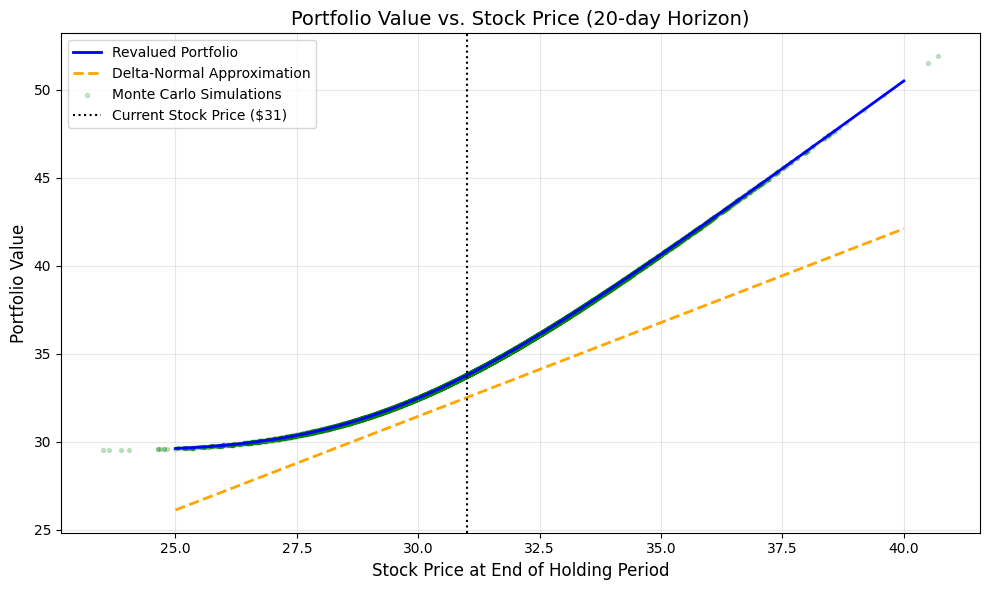

In [121]:
# (i) Delta–Normal Approximation
# Using the second method's idea for VaR calculation:

# Mean change due to time decay over holding period
mean_change = portfolio_theta * dt

# Standard deviation of portfolio change due to delta exposure
std_portfolio = portfolio_delta * std_S

# Using the 5% quantile (z_0.05) of the normal distribution
z_5 = st.norm.ppf(0.05)  # approximately -1.645

# Calculate portfolio quantile
portfolio_quantile = mean_change + std_portfolio * z_5

# VaR (expressed as a positive loss)
VaR_delta_normal = -portfolio_quantile if portfolio_quantile < 0 else 0

# Standard (left-tail) ES calculation
ES_delta_normal = -(mean_change - std_portfolio * st.norm.pdf(z_5) / 0.05)

print("\n(D) Delta-Normal Approximation (20-day, 5% level) [Standard ES]:")
print(f"    Mean change = {mean_change:.4f}")
print(f"    Std of change = {std_portfolio:.4f}")
print(f"    VaR = {VaR_delta_normal:.4f}")
print(f"    ES (Standard) = {ES_delta_normal:.4f}")

# (ii) Monte Carlo Simulation
n_sims = 10000
np.random.seed(42)  # for reproducibility

# Simulate stock returns over dt using lognormal dynamics (zero drift)
Z = np.random.randn(n_sims)
S_final = S * np.exp(-0.5 * annual_vol**2 * dt + annual_vol * math.sqrt(dt) * Z)

# New time to maturity for the options (accounting for time decay)
T_new = max(T - dt, 0.0)

# Vectorized repricing of options at the new stock prices
def batch_black_scholes_call(s_array, K, r, T, iv):
    if T <= 0:
        return np.maximum(s_array - K, 0)
    d1 = (np.log(s_array / K) + (r + 0.5 * iv**2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    return s_array * st.norm.cdf(d1) - K * np.exp(-r * T) * st.norm.cdf(d2)

def batch_black_scholes_put(s_array, K, r, T, iv):
    if T <= 0:
        return np.maximum(K - s_array, 0)
    d1 = (np.log(s_array / K) + (r + 0.5 * iv**2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    return K * np.exp(-r * T) * st.norm.cdf(-d2) - s_array * st.norm.cdf(-d1)

# Reprice the options using vectorized functions
call_new = batch_black_scholes_call(S_final, K, r, T_new, iv)
put_new = batch_black_scholes_put(S_final, K, r, T_new, iv)
portfolio_new = call_new + put_new + S_final

# Change in portfolio value
portfolio_change = portfolio_new - portfolio_value_0

# Compute VaR and ES at 5% level using Monte Carlo
VaR_MC = -np.percentile(portfolio_change, 5)
losses = -portfolio_change[portfolio_change < np.percentile(portfolio_change, 5)]
ES_MC = losses.mean() if len(losses) > 0 else np.nan

print("\n(D) Monte Carlo Simulation (20-day, 5% level):")
print(f"    VaR = {VaR_MC:.4f}")
print(f"    ES = {ES_MC:.4f}")

# (E) Graphing the portfolio value vs. stock price.
S_range = np.linspace(25, 40, 200)

# Use vectorized functions to reprice options for the S range
call_values = batch_black_scholes_call(S_range, K, r, T_new, iv)
put_values = batch_black_scholes_put(S_range, K, r, T_new, iv)
portfolio_values = call_values + put_values + S_range

# Linear approximation: portfolio_value_0 + portfolio_delta*(S_range - S) + portfolio_theta*dt
linear_approx = portfolio_value_0 + portfolio_delta * (S_range - S) + portfolio_theta * dt

# Create visualization
plt.figure(figsize=(10, 6))
plt.plot(S_range, portfolio_values, label='Revalued Portfolio', color='blue', linewidth=2)
plt.plot(S_range, linear_approx, label='Delta-Normal Approximation', linestyle='--', color='orange', linewidth=2)
plt.scatter(S_final, portfolio_new, s=8, alpha=0.2, color='green', label='Monte Carlo Simulations')
plt.axvline(x=S, color='black', linestyle=':', label=f'Current Stock Price (${S})')

# Improve plot formatting
plt.xlabel('Stock Price at End of Holding Period', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.title('Portfolio Value vs. Stock Price (20-day Horizon)', fontsize=14)
plt.legend(loc='best', frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()